# Generate SFS as a function of sigma and population parameters for burnin estimations

#### Chris Porras

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rc = {'lines.linewidth': 3, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5',
      'axes.font': 'arial'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette('colorblind')
%matplotlib inline
from scipy.ndimage.filters import laplace

### Explicit and implicit mutation rate simulations

In [3]:
def SS_WF_sim(pop_size,mu,s,m,num_reps,num_gen,dims):
    #Pre-allocate and initialize
    f = np.zeros((num_gen,num_reps)+dims)
    f[0] = 1/pop_size
    for j in range(num_gen-1):
        #Wright-Fisher diffusion w/Stepping Stone migration
        df = mu*(1-2*f[j])-s*f[j]*(1-f[j]) \
        +m*laplace(f[j],mode='wrap')
        #bounds allele frequencies
        p = np.clip(a= f[j] + df ,a_min=0,a_max=1)
        #genetic drift sampling
        f[j+1]= np.random.binomial(pop_size,p)/pop_size
    return f

In [4]:
def implicit_mut_sim(pop_size,s,m,num_reps,num_gen,dims):
    #Pre-allocate and initialize
    f = np.zeros((num_gen,num_reps)+dims)
    f[0] = 1/pop_size
    for j in range(num_gen-1):
        #Wright-Fisher diffusion w/Stepping Stone migration
        df = -s*f[j]*(1-f[j]) + m*laplace(f[j],mode='wrap')
        #bounds allele frequencies
        p = np.clip(a= f[j] + df ,a_min=0,a_max=1)
        #genetic drift sampling w/ implicit mut
        f[j+1] = np.random.binomial(pop_size,p)/pop_size
        # if all elements of a replicate at time j are 0, reset to 1/N
        f[j+1,np.count_nonzero(f[j],axis=(1,2))==0] = 1/pop_size
    return f

#### For now, will continue with explicit sim

In [5]:
# Population parameters
pop_size = 10**3
mu = 10**-4
s = 10**-2
m = 10**-1
num_reps = 10
num_gen = 10**4
dims = (10,10)

In [6]:
f = SS_WF_sim(pop_size,mu,s,m,num_reps,num_gen,dims)

### $\langle \zeta \rangle$ calculator

In [13]:
from scipy.special import binom
def freq_sfs(f,n):
    if np.isscalar(f):
        sfs = np.zeros(n+1)
    else:
        sfs = np.zeros(tuple([n+1]) + f.shape)
    for j in range(n+1):
        sfs[j] = binom(n,j)*f**j * (1-f)**(n-j)
    return sfs

In [8]:
# Calculate pairwise diversity from sfs
pi_sfs = freq_sfs(f,n=2)
# average over replicates and spatial dimensions, want pi over time
avg_pi_sfs = np.mean(pi_sfs,axis=(2,3,4))

### Plot $\pi$ to estimate burnin

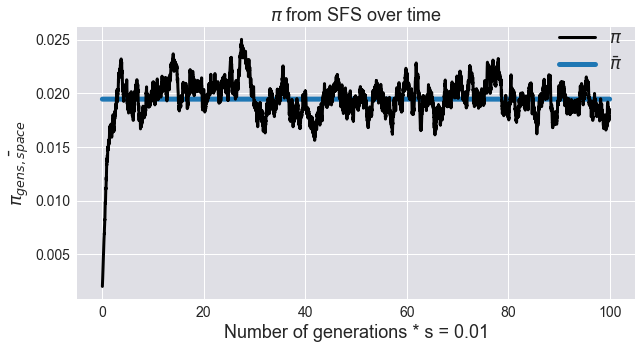

In [210]:
plt.figure(figsize=(10,5))
#Plot pi w/ time scaled by s
plt.plot(np.arange(avg_pi_sfs.shape[1])*s, 
         avg_pi_sfs[1],"-k",zorder=3, label='$\pi$')
#Plot E[pi]
plt.plot(np.arange(avg_pi_sfs.shape[1])*s,
         [np.mean(avg_pi_sfs[1])]*avg_pi_sfs.shape[1],
         label=r'$\bar{\pi}$',linewidth=5)
plt.legend(loc = (.85,.8),fontsize=18)
plt.title(r'$\pi$ from SFS over time')
plt.xlabel(f'Number of generations * s = {s}')
plt.xticks(fontsize=14)
plt.ylabel(r'$\bar{\pi_{gens,space}}$')
plt.yticks(fontsize=14)
plt.show()

In [265]:
# Report first value in pi that is within sigma^2 of the mean
print('burnin time:',np.where(np.abs(avg_pi_sfs[1]-np.mean(pi_sfs[1])) < np.std(pi_sfs[1]))[0][0])

burnin time: 76


In [264]:
print(1/s,10/s)

100.0 1000.0


### > Burnin time is $\approx \bf{\frac{1}{s}}$ <

#### Test burnin prediction with a range of s

In [288]:
def burnin_plot_of_s(s_arr):
    ### make plot
#     plt.figure(figsize=(15,10))
    for i in range(len(s_arr)):
        s=s_arr[i]
        # simulate frequencies
        f = SS_WF_sim(pop_size,mu,s,m,num_reps,num_gen,dims)
        # Calculate pairwise diversity from sfs
        pi_sfs = freq_sfs(f,n=2)
        # average over replicates and spatial dimensions, want pi over time
        avg_pi_sfs = np.mean(pi_sfs,axis=(2,3,4))
        #Plot pi w/ time scaled by s
        plt.plot(np.arange(avg_pi_sfs.shape[1])*s, 
                 avg_pi_sfs[1],zorder=3, label=f's={s}')
        #Plot E[pi]
        plt.plot(np.arange(avg_pi_sfs.shape[1])*s,
                 [np.mean(avg_pi_sfs[1])]*avg_pi_sfs.shape[1],
                 label=f'mean{np.mean(avg_pi_sfs[1])} w/ s={s}',linewidth=5)
        plt.legend(loc = (.7,.7),fontsize=18)
        print('burnin time:',np.where(np.abs(avg_pi_sfs[1]-np.mean(pi_sfs[1])) < np.std(pi_sfs[1]))[0][0],1/s,pop_size*s)
        plt.title(r'$\pi$ from SFS over time')
        plt.xlabel(f'Number of generations * s')
        plt.xticks(fontsize=14)
        plt.ylabel(r'$\bar{\pi_{gens,space}}$')
        plt.yticks(fontsize=14)
        plt.show()

In [291]:
s_arr = [10**-2,10**-3,10**-4]
n = [2,100,1000]

# Population parameters
pop_size = 10**2
mu = 10**-4
m = 10**-1
num_reps = 1
num_gen = 10**4
dims = (50,1)

burnin time: 0 100.0 1.0


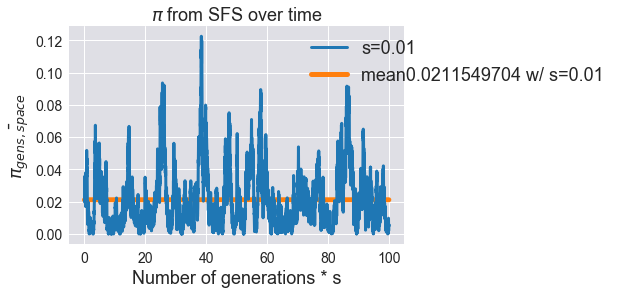

burnin time: 0 1000.0 0.1


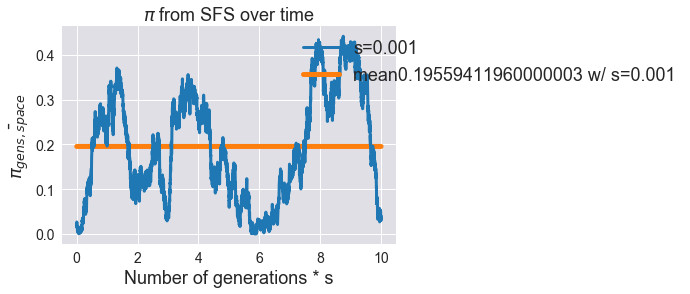

burnin time: 0 10000.0 0.01


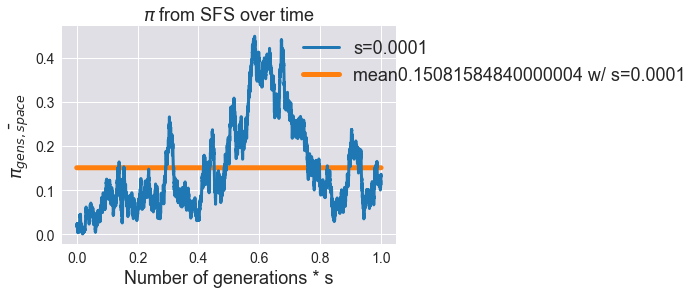

In [292]:
burnin_plot_of_s(s_arr)

### Downsample simulated frequency trajectories at 1/s

In [7]:
def downsample_sim(pop_size,mu,s,m,num_reps,num_intervals,dims):
    if type(dims)!=tuple:
        dims = tuple([dims])
    
    #Pre-allocate and initialize
    x = np.zeros((num_intervals,num_reps)+dims)
    x[0] = 1/pop_size
    f = np.zeros((int(1/s),num_reps)+dims)
    for i in range(x.shape[0]-1):
        f[0] = x[i]
        for j in range(int(1/s)-1):
            #Wright-Fisher diffusion w/Stepping Stone migration
            df = mu*(1-2*f[j])-s*f[j]*(1-f[j]) \
            +m*laplace(f[j],mode='wrap')
            #bounds allele frequencies
            p = np.clip(a= f[j] + df ,a_min=0,a_max=1)
            #genetic drift sampling
            f[j+1]= np.random.binomial(pop_size,p)/pop_size
        #Collect frequencies every 1/s generations
        x[i+1] = f[-1]
    return x

### Gaussian sampling over a range of sigma

In [8]:
from scipy.ndimage import gaussian_filter

In [9]:
def sample_f(f):
    sig_arr = np.arange(f.shape[-1])+1
    F = np.zeros((tuple([len(sig_arr)])+f.shape))
    
    for i,sig in enumerate(sig_arr):
        for j in range(f.shape[0]):
            for k in range(f.shape[1]):
                F[i,j,k] = gaussian_filter(f[j,k],sigma=sig,mode = "wrap")
    return F

> Potentially better storage format. Collect all simulated values for range of sigma in single array

### Calculate SFS as a function of s and sigma

In [29]:
def plot_sfs(f,n,s,sig_list):
    #sample from f with range of sigma
    F = sample_f(f)
    # j is sample size out of n
    j = np.arange(1,n+1) # ignore j=0  
    #average sampled f over intervals,reps,dims
    sfs = freq_sfs(F,n).T
    if type(dims)!=int:
        #avg over both spatial dimensions
        sfs_avg = np.mean(sfs,axis=(1,2,3,4))
    else:
        #only 1 spatial dimension
        sfs_avg = np.mean(sfs,axis=(1,2,3))
    #make plot over j for all sfs(s,sigma)
    plt.figure(figsize=(10,5))
    title = (r'$\zeta_{s,\sigma}$'+f' n={n} s={s} ' \
            + r'$N\mu$='+f'{pop_size*mu} ' \
            + r'$Ns$='+f'{pop_size*s} ' \
            + r'$d_c=$'+f'{np.sqrt(m/s)}')
    plt.title(title)
    plt.xlabel(r'$j$')
    plt.ylabel(r'$\zeta_{s,\sigma}$')
    for sig in sig_list:
        label = f'$\sigma$ = {sig+1}'
        plt.loglog(j,sfs_avg[sig,j[0]:],label=label)
        plt.xlim((0,10))
        plt.ylim((10**-13,10**-1))
    plt.legend()
    plt.show()
    return sfs

#### sampling effect on SFS converges for increasing number of 1/s frequency intervals collected

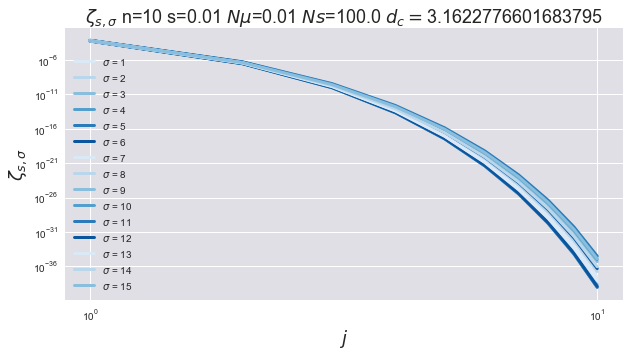

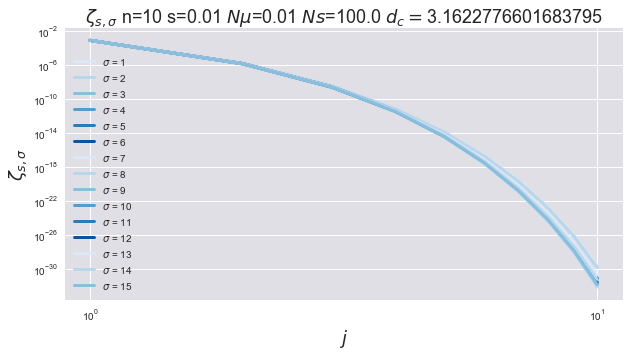

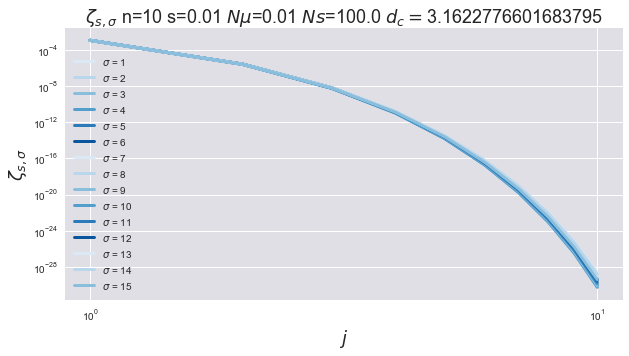

In [70]:
s = 10**-2
n = 10

# Population parameters
pop_size = 10**4
mu = 10**-6
m = 10**-1
num_reps = 1
num_gen = 10**4
dims = (15)

num_intervals=[10,100,1000]

#small number of intervals to large number of intervals
for intervals in num_intervals:
    plot_sfs(downsample_sim(pop_size,mu,s,m,num_reps,intervals,dims),n,s)

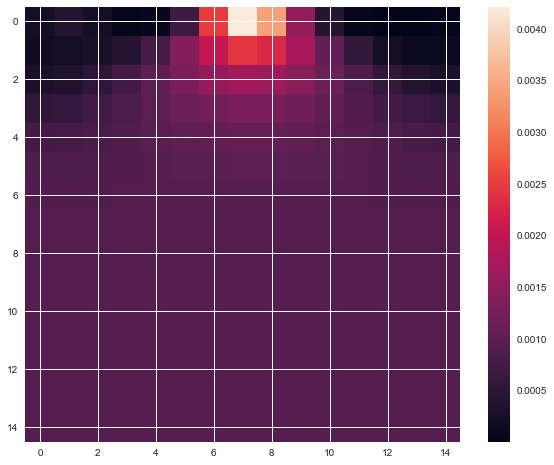

dc= 1.0
1.561 1.5610000000000002


In [13]:
### Checking sampling func. Maintains normalization
## and works only on spatial dimensions

s = 10**-1
n = [2,100]

# Population parameters
pop_size = 10**3
mu = 10**-4
m = 10**-1
num_reps = 1
num_gen = 10**4
dims = (15)
num_intervals = 100


f = downsample_sim(pop_size,mu,s,m,num_reps,num_intervals,dims)
plt.figure(figsize=(10,8))
plt.imshow(sample_f(f)[:,-1,0,:])
plt.colorbar()
plt.show()
print('dc=',np.sqrt(m/s))
print(np.sum(f),np.sum(sample_f(f)[-1]))

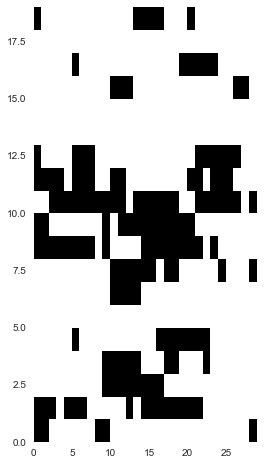

In [63]:
plt.figure(figsize=(4,8))
plt.pcolor(np.arange(30),np.arange(20),f[-20:,0,:] > 0, cmap='Greys')

In [47]:
sum(f==0).shape

(1, 30)